## Event and Schedule class

In [ ]:
import scipy.stats as sts
import heapq
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

from collections import deque
import numpy as np

#adapt the code from classes 
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

## Extended Service

In [ ]:
class ExtendedService: 
    '''
    Tracks the number of people in the extended queue. 
    It performs serving customers in the extended queue. 

    Parameters
    ----------
    manager_distribution: scipy.stats distribution
        Manager service time distribution

    Attributes
    ----------
    manager_distribution : scipy.stats distribution
        Manager service time distribution
    people_being_served: int 
        Check if the server is serving someone at the moment 
    people_in_queue: int
        The number of people in the queue 
    leave_time: deque[Passenger]
        A queue to store all the leave time of customers

    '''
    def __init__(self, manager_distribution):
        self.manager_distribution = manager_distribution
        self.people_being_served = 0
        self.people_in_queue = 0 
        self.leave_time = deque()
        
    def add_customer(self, schedule): 
        '''
        Add customers into the schedule 

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None
        '''
        # Add the customer to the queue
        self.people_in_queue += 1
        

        # print(
        #     f'      {round(9+ schedule.now//60)}h{round(schedule.now%60)}m: ⭐️ Add customer to the extended service. '
        #     f'Extended queue length: {self.people_in_queue}')
        if (self.people_being_served < 1) and (self.people_in_queue == 1): #the server is available and no one in the front 
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)

    def start_serving_customer(self, schedule):
        '''
        Start serving a customer 

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None
        '''
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # print(
            # f'      {round(9+ schedule.now//60)}h{round(schedule.now%60)}m: ⭐️ Start serving customer from to the extended queue. '
            # f'Queue length: {self.people_in_queue}')
        # Schedule when the server will be done with the customer.
        # Generate a random service time from the service distribution.
        schedule.add_event_after(
            self.manager_distribution.rvs(),
            self.finish_serving_customer)
    
    def finish_serving_customer(self, schedule):
        '''
        Finish serving a customer. If there are still people in the queue, start serving again. 

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None
        '''
        # Remove the customer from the server
        self.people_being_served -= 1


        # print('     ⭐️ finish serving')
        self.leave_time.append(schedule.now)

        # print(
        #     f'      {round(9+ schedule.now//60)}h{round(schedule.now%60)}m: ⭐️ Stop serving customer in the extended queue.  '
        #     f'Extended queue length: {self.people_in_queue}')
        
        if self.people_in_queue >= 1:

            # print("⭐️  check if I can serve again")
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)    

## Queue & Queue System class 

In [ ]:
class Queue:
    '''
    Tracks the number of people and their wait time in the queue. 
    Schedule customer arrival to the queue. 

    Parameters
    ----------
    service_distribution: scipy.stats distribution
        service time distribution
    extended_service: object
        ExtendedService object 

    Attributes
    ----------
    service_distribution : scipy.stats distribution
        service time distribution
    people_in_queue: int
        The number of people in the queue 
    people_being_served: int 
        Check if the server is serving someone at the moment        
    extended_service: object 
        ExtendedService object 
    arrival_time: deque
        Arrival time for customers
    wait_time: list 
        Wait time for customers for regular queues and extension service 
    no_extension_wait: list 
        Wait time for customers for regular queues
    max_queue_length: int
        Maximum queue length for regular queues  
    

    '''
    
    def __init__(self, service_distribution, extended_service):
        # Store the service distribution and queuesystem
        self.service_distribution = service_distribution
        # We start with an empty queue and the server not busy
        self.people_being_served = 0
        self.people_in_queue = 0
        self.extended_service = extended_service
        self.arrival_time = deque() #the first customer starts with 0 
        self.wait_time = []
        self.no_extension_wait = []
        self.max_queue_length = 0
        self.queue_length = []

        

    def add_customer(self, schedule, queue_num):
        '''
        Add customers into the schedule 

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation
        queue_num: int
            The queue number to add customers 

        Returns
        ----------
        None
        '''        
        # Add the customer to the queue
        self.people_in_queue += 1
        self.arrival_time.append(schedule.now)

        self.max_queue_length = max(self.max_queue_length, self.people_in_queue)
        self.queue_length.append(self.people_in_queue)

        # print(
        #     f'⏰ {schedule.now}m: Add customer to queue {queue_num} '
        #     f'Queue length: {self.people_in_queue}')
        if (self.people_being_served < 1) and (self.people_in_queue == 1): #the server is free and no one in the front 
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer, queue_num)
            
    def start_serving_customer(self, schedule, queue_num):
        '''
        Start serving a customer 

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation
        queue_num: int
            The queue number 

        Returns
        ----------
        None
        '''
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # print(
        #     f'⏰ {schedule.now}m: Start serving customer in queue {queue_num}. '
        #     f'Queue length: {self.people_in_queue}')
        # Schedule when the server will be done with the customer.
        # Generate a random service time from the service distribution.
        schedule.add_event_after(
            self.service_distribution.rvs(),
            self.finish_serving_customer, queue_num)
            
    def finish_serving_customer(self, schedule, queue_num):
        '''
        Finish serving a customer. If there are still people in the queue, start serving again. 

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation
        queue_num: int
            The queue number            

        Returns
        ----------
        None
        '''
        # Remove the customer from the server
        self.people_being_served -= 1 

        #check the leave time and arrival time 
        leaving_time = schedule.now
        arrival_time = self.arrival_time.popleft()

        #check if the customer will need extended serive
        if random.random() <= 0.05: 
            # print("extended service queue", queue_num)
            self.extended_service.add_customer(schedule)
            self.wait_time.append((arrival_time, 1)) #create tuple (arrival time, 1) to mark for extended service
            

        else:
            # print(f'🐐 current leaving time {round(9+ schedule.now//60)}h{round(schedule.now%60)}m')
            self.wait_time.append((leaving_time - arrival_time, 0))  #0 indicate no extended service time 
        
        self.no_extension_wait.append(leaving_time - arrival_time)

        # print(
        #     f'⏰ {schedule.now}m: Stop serving customer in queue {queue_num}.  '
        #     f'Queue length: {self.people_in_queue}')

        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer, queue_num)
    
    

class QueueSystem:
    '''
    Contains all the queues in the system.

    Parameters
    ----------
    arrival_distribution: scipy.stats distribution
        Customer arrival distribution for all queues
    service_distribution: scipy.stats distribution
        Service distribution for queues 
    extended_service: object
        An ExtendedService object 
    n_queue: int 
        Number of queues the system has to serve customers 

    Attributes
    ----------
    queues: list[Queue]
        A list of all the queues
    arrival_distribution: scipy.stats distribution
        Customer arrival distribution for all queues

    '''
    def __init__(self, arrival_distribution, service_distribution, extended_service, n_queue):
        self.queue = [Queue(service_distribution, extended_service) for _ in range(n_queue)]
        self.arrival_distribution = arrival_distribution 
        self.total_customers = 0 
        

    def add_customer(self, schedule):
        '''
        Add customers into the schedule 

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None
        '''    
        self.total_customers += 1
        # Query all the people in different queues
        length_queues = [queue.people_in_queue for queue in self.queue]

        # Find the shortest queue's index(if the same, queury the first one)
        queue_num = length_queues.index(min(length_queues))        
        
        # print(f"    ⏰ {round(9+ schedule.now//60)}h{round(schedule.now%60)}m")

        if schedule.now <= 540: #9 am - 6 pm is 540 min
            # Add this customer to the shortest queue and pass the assigned queue number 
            self.queue[queue_num].add_customer(schedule, queue_num)
        
            schedule.add_event_after(
                self.arrival_distribution.rvs(),
                self.add_customer)            

    def run(self, schedule):
        '''
        Start running the system

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None
        '''         
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        # print('first customer',              
        #     f'⏰ {round(9+ schedule.now//60)}h{round(schedule.now%60)}m: Add customer to queue {0} '
        #     f'Queue length: {self.queue[0].people_in_queue}')     
        
    def get_average_wait_time(self): 
        '''
        Calculate average wait time regular and extended service 

        Parameters
        ----------
        None 

        Returns
        ----------
        Average wait time 
        '''         
        #get average wait time for all queues 
        total_wait_time = 0 
        n_customer = sum([len(queue.wait_time) for queue in self.queue]) 
        extended_arrival_heap = []

        for queue in self.queue: 
            for time, extended_service in queue.wait_time: 
                if extended_service == 1: #if extended service exists
                    heapq.heappush(extended_arrival_heap, time)
                else: 
                    total_wait_time += time 

        
        #calculate wait time for extended queue 
        extended_leave_deque = self.queue[0].extended_service.leave_time
        length = len(extended_arrival_heap)


        # print("extended_arrival_heap length", len(extended_arrival_heap), extended_arrival_heap)
        # print("length", length, extended_leave_deque)

        for _ in range(length):             
            extended_arrival_time = heapq.heappop(extended_arrival_heap)
            extended_leave_time = extended_leave_deque.popleft()
            extended_wait_time = extended_leave_time - extended_arrival_time
            total_wait_time += extended_wait_time        
        return total_wait_time/n_customer

    
    def get_max_queue_length(self): 
        '''
        Calculate max queue length for regular queues

        Parameters
        ----------
        None 

        Returns
        ----------
        Maximum queue length 
        '''         
        max_length = 0
        for queue in self.queue: 
            max_length = max(queue.max_queue_length, max_length)
        return max_length

    def get_average_queue_length(self): 
        '''
        Calculate average length for regular queues

        Parameters
        ----------
        None 

        Returns
        ----------
        Average queue length 
        '''       
        n = 0  
        all_queue_length = 0
        for queue in self.queue: 
            all_queue_length += sum(queue.queue_length)
            n+= len(queue.queue_length)
        return all_queue_length/n

    def get_no_extension_average_wait_time(self): 
        total_wait_time = 0
        n = 0
        for queue in self.queue:
            total_wait_time += np.sum(queue.no_extension_wait)
            n += len(queue.no_extension_wait)
        return total_wait_time/n 



def run_simulation(arrival_distribution, service_distribution, manager_distribution, n_queue):
    """
    Run one simulation with different arrival rates, the service time distribution, and manager time distribution.
    It can also adjust the numbers of servers by n_queue
    """
    schedule = Schedule()
    extended_service = ExtendedService(manager_distribution)
    queue_system = QueueSystem(arrival_distribution, service_distribution, extended_service, n_queue)
    queue_system.run(schedule)
    
    # End when we finish serving all the customers 
    while schedule.priority_queue:
        schedule.run_next_event()
    # print('get wait time', queue_system.get_average_wait_time())
    # print('max_queue length', queue_system.get_max_queue_length())
    return queue_system

## Run experiments functions

In [ ]:
def run_experiment(arrival_distribution, service_distribution, manager_distribution, n_queue_list, num_trials):
    '''
    Run an experiment with different arrival rates, the service time distribution, and manager time distribution.
    It can also adjust the numbers of servers by n_queue_list.

    Parameters
    ----------
    arrival_distribution: scipy.stats distribution
        Customer arrival distribution for all queues
    service_distribution: scipy.stats distribution
        Service distribution for queues 
    manager_distribution: scipy.stats distribution
        Manager distribution for queues         
    n_queue_list: list 
        A list of number of queues the system has to serve customers 
    num_trials: int
        Number of trials for the experiment 

    Return 
    ----------
    wait_results_mean: array
        Mean of the wait time (extended service included)
    wait_results_std_err: array
        Standard deviation of the wait time (extended service included)
    max_queue_results_mean: array
        Mean of the maximum queue (extended service excluded)
    max_queue_results_std_err: array
        Standard deviation of the maximum queue (extended service excluded)   
    avg_queue_results_mean: array
        Mean of the average queue length(extended service encluded)
    avg_queue_results_std_err: array
        Standard deviation of the average queue length(extended service excluded)
    no_extension_wait_results_mean: array
        Mean of the wait time (extended service excluded)
    no_extension_wait_results_std_err: array
        Standard deviation of the wait time (extended service excluded)    
    '''
    
    # We record only the mean and standard error of the mean for each experiment
    wait_results_mean = []
    wait_results_std_err = []
    no_extension_wait_results_mean = []
    no_extension_wait_results_std_err = []    
    max_queue_results_mean = []
    max_queue_results_std_err = []
    avg_queue_results_mean = []
    avg_queue_results_std_err = []
    total_customer_mean = []
    total_customer_std = []

    avg_wait_times = []
    no_extension_wait_times = []    
    max_queue_lengths = []
    average_queue_lengths = []
    total_customers = []
    for n_queue in n_queue_list: 
        for trial in range(num_trials):
            queue_system = run_simulation(arrival_distribution, service_distribution, manager_distribution, n_queue)

            #calculate average wait time 
            avg_wait_time = queue_system.get_average_wait_time()
            avg_wait_times.append(avg_wait_time)

            #calculate no extension wait time 
            no_extension_wait_time = queue_system.get_no_extension_average_wait_time()
            no_extension_wait_times.append(no_extension_wait_time)

            #calculate max queue length
            max_queue_length = queue_system.get_max_queue_length()
            max_queue_lengths.append(max_queue_length)
            
            
            # calculate average queue length 
            average_queue_length = queue_system.get_average_queue_length()
            average_queue_lengths.append(average_queue_length)   


            #calulate total customers being served 
            total_customers.append(queue_system.total_customers)


        wait_results_mean.append(np.mean(avg_wait_times))
        wait_results_std_err.append(sts.sem(avg_wait_times))   

        no_extension_wait_results_mean.append(np.mean(no_extension_wait_times))
        no_extension_wait_results_std_err.append(sts.sem(no_extension_wait_times))        

        max_queue_results_mean.append(np.mean(max_queue_lengths))
        max_queue_results_std_err.append(sts.sem(max_queue_lengths))

        avg_queue_results_mean.append(np.mean(average_queue_lengths))
        avg_queue_results_std_err.append(sts.sem(average_queue_lengths))

        total_customer_mean.append(np.mean(total_customers))
        total_customer_std.append(sts.sem(total_customers))

        
    # Convert lists to arrays so we can easily add, subtract, and multiply them
    wait_results_mean = np.array(wait_results_mean)
    wait_results_std_err = np.array(wait_results_std_err)
    max_queue_results_mean = np.array(max_queue_results_mean)
    max_queue_results_std_err = np.array(max_queue_results_std_err)
    avg_queue_results_mean = np.array(avg_queue_results_mean)
    avg_queue_results_std_err = np.array(avg_queue_results_std_err)   
    no_extension_wait_results_mean = np.array(no_extension_wait_results_mean)
    no_extension_wait_results_std_err = np.array(no_extension_wait_results_std_err)
    total_customer_mean = np.array(total_customer_mean)
    total_customer_std = np.array(total_customer_std)
    
    return wait_results_mean, wait_results_std_err, max_queue_results_mean, max_queue_results_std_err, avg_queue_results_mean, avg_queue_results_std_err, no_extension_wait_results_mean, no_extension_wait_results_std_err, total_customer_mean, total_customer_std


def make_error_plot(queue_type, n_queue_list, mean, std_err, observed_variable):
    '''
    Plot the empirical mean and 95% confidence interval of the mean of the queue
    length. Also plot the theoretical value for the average queue length using the
    supplied theoretical function (a function of rho). ////////- -- to fix
    '''
    
    plt.figure(figsize=(8, 6))
    plt.title(f'{observed_variable} for an {queue_type} queue')
    plt.xlabel('number of cashier')
    plt.ylabel(f'{observed_variable}')

    plt.errorbar(
        n_queue_list, mean, 1.96 * std_err,
        color='black', marker='o', capsize=5, linestyle='--', linewidth=1,
        label='empirical')
    
    for index in range(len(mean)):
        y = mean + 1.2 * std_err
        plt.text(index + 1.1, y[index] + 2.3, round(y[index],2), size=12)

    plt.legend()
    plt.show()

## Code test against theoretical result (M/G/1)

In [ ]:
# Uniform distribution 
lamb = 1
arrival_distribution = sts.uniform(loc = lamb, scale = 0)

# Normal distribution 
mean_serve_time = 0.1
service_distribution = sts.norm(loc= mean_serve_time, scale = 0)

# we assume manager takes no time 
manager_distribution = sts.norm(loc=0, scale =0) 

n_queue_list = [1]
num_trials = 50

wait_results_mean, wait_results_std_err, max_queue_results_mean, max_queue_results_std_err, avg_queue_results_mean, avg_queue_results_std_err, no_extension_wait_results_mean, no_extension_wait_results_std_err, total_customer_mean, total_customer_std = run_experiment(arrival_distribution, service_distribution, manager_distribution, n_queue_list, num_trials)
wait_results_mean, wait_results_std_err, max_queue_results_mean, max_queue_results_std_err, avg_queue_results_mean, avg_queue_results_std_err, no_extension_wait_results_mean, no_extension_wait_results_std_err, total_customer_mean, total_customer_std

(array([0.1]),
 array([7.93016446e-19]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([0.]),
 array([0.1]),
 array([0.]),
 array([541.]),
 array([0.]))

In [ ]:
mean_serve_time_list = [0.1, 0.3, 0.5, 0.7, 0.9]


def theoretical_MG1(rho, tau, sigma):
    return rho**2 * (1 + sigma**2 / tau**2)/ (2 * (1-rho)) 

def theoretical_test_plot(mean_serve_time_list): 
    avg_queue_means = []
    avg_queue_stds = []
    avg_queue_theoretical = []
    num_trials = 10
    sigma = 0.1
    for mean_serve_time in mean_serve_time_list:
        service_distribution = sts.norm(loc= mean_serve_time, scale = sigma)
        wait_results_mean, wait_results_std_err, max_queue_results_mean, max_queue_results_std_err, avg_queue_results_mean, avg_queue_results_std_err, no_extension_wait_results_mean, no_extension_wait_results_std_err, total_customer_mean, total_customer_std = run_experiment(arrival_distribution, service_distribution, manager_distribution, n_queue_list, num_trials)
        avg_queue_means.append(avg_queue_results_mean)
        avg_queue_stds.append(avg_queue_results_std_err)

        rho = lamb * mean_serve_time
        tau = mean_serve_time
        avg_queue_theoretical.append(theoretical_MG1(rho, tau, sigma))
    
    

    plt.errorbar(
    mean_serve_time_list, avg_queue_means, 1.96 * np.array(avg_queue_stds),
    color='black', marker='o', capsize=5, linestyle='--', linewidth=1,
    label='empirical')

    plt.plot(
    mean_serve_time_list, avg_queue_theoretical,
    color='red', marker='o', linestyle='--', linewidth=1,
    label='theoretical M/G/1')

    plt.title("Queue length against different service time distribution")
    plt.xlabel('Service time (min)')
    plt.ylabel('Average queue length')
    plt.legend()
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


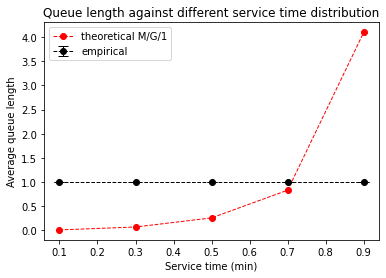

In [ ]:
theoretical_test_plot(mean_serve_time_list)

In [ ]:
lamb = 1
arrival_distribution = sts.expon(loc = lamb)

mean_service_time = 3
service_distribution = sts.norm(loc= mean_service_time, scale = 1)

manager_distribution = sts.norm(loc=4, scale =1) 

n_queue_list = [i for i in range(1,11)]
num_trials = 400
wait_results_mean, wait_results_std_err, max_queue_results_mean, max_queue_results_std_err, avg_queue_results_mean, avg_queue_results_std_err, no_extension_wait_results_mean, no_extension_wait_results_std_err, total_customer_mean, total_customer_std = run_experiment(arrival_distribution, service_distribution, manager_distribution, n_queue_list, num_trials)



## Experimental results 

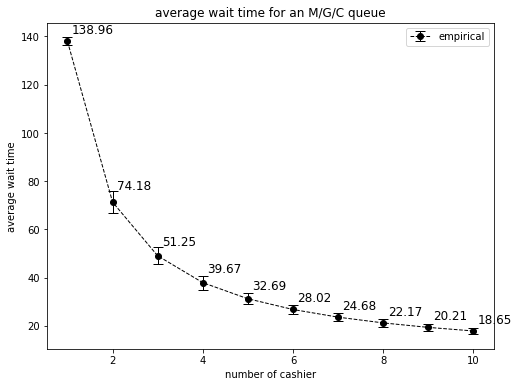

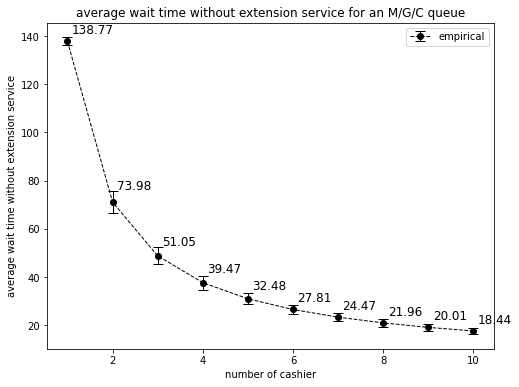

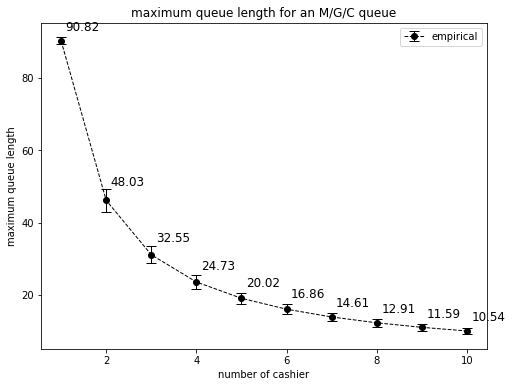

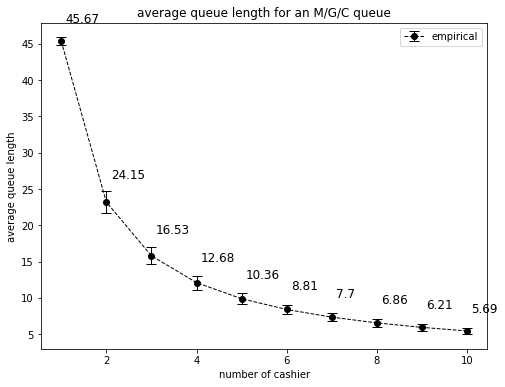

In [ ]:
queue_type = 'M/G/C'
make_error_plot(queue_type, n_queue_list, wait_results_mean, wait_results_std_err, 'average wait time')
make_error_plot(queue_type, n_queue_list, no_extension_wait_results_mean, no_extension_wait_results_std_err, 'average wait time without extension service')
make_error_plot(queue_type, n_queue_list, max_queue_results_mean, max_queue_results_std_err,'maximum queue length')
make_error_plot(queue_type, n_queue_list, avg_queue_results_mean, avg_queue_results_std_err,'average queue length')


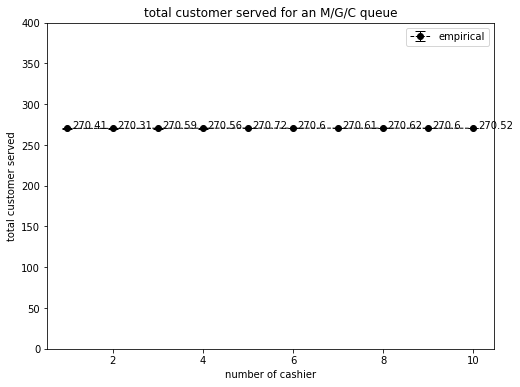

In [ ]:
def make_error_plot_total_customer(queue_type, n_queue_list, mean, std_err, observed_variable):
    '''
    Plot the empirical mean and 95% confidence interval of the mean of the queue
    length. Also plot the theoretical value for the average queue length using the
    supplied theoretical function (a function of rho). ////////- -- to fix
    '''
    
    plt.figure(figsize=(8, 6))
    plt.title(f'{observed_variable} for an {queue_type} queue')
    plt.xlabel('number of cashier')
    plt.ylabel(f'{observed_variable}')

    plt.errorbar(
        n_queue_list, mean, 1.96 * std_err,
        color='black', marker='o', capsize=5, linestyle='--', linewidth=1,
        label='empirical')
    
    for index in range(len(mean)):
        y = mean 
        plt.text(index + 1.1, y[index] + 0.1, round(y[index],2), size=10)
    
    plt.ylim([0, 400])
    plt.legend()
    plt.show()
make_error_plot_total_customer(queue_type, n_queue_list, total_customer_mean, total_customer_std,'total customer served')

In [ ]:
real_total_customer_mean= total_customer_mean - wait_results_mean * 0.4
real_total_customer_std = total_customer_std

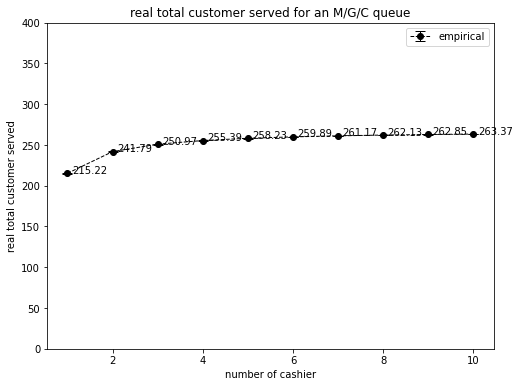

In [ ]:
make_error_plot_total_customer(queue_type, n_queue_list, real_total_customer_mean, real_total_customer_std,'real total customer served')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "./drive/My Drive/Class prep/CS166/CS166Assignment_1.ipynb" ./
!jupyter nbconvert --to pdf 'CS166Assignment_1.ipynb'

[NbConvertApp] Converting notebook CS166Assignment_1.ipynb to pdf
[NbConvertApp] Support files will be in CS166Assignment_1_files/
[NbConvertApp] Making directory ./CS166Assignment_1_files
[NbConvertApp] Making directory ./CS166Assignment_1_files
[NbConvertApp] Making directory ./CS166Assignment_1_files
[NbConvertApp] Making directory ./CS166Assignment_1_files
[NbConvertApp] Making directory ./CS166Assignment_1_files
[NbConvertApp] Making directory ./CS166Assignment_1_files
[NbConvertApp] Making directory ./CS166Assignment_1_files
[NbConvertApp] Writing 100664 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 211698 bytes to CS166Assignment_1.pdf
